<a href="https://colab.research.google.com/github/alex-jk/Predicting-Fire-Incidents/blob/main/Fire_Incidents_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Fire Incidents Prediction

### Import the necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from itertools import cycle, islice
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
from sklearn.preprocessing import MinMaxScaler
from keras.layers import Dense
from keras.models import Sequential
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [2]:
from google.colab import drive
drive.mount('/content/drive')
%cd "/content/drive/My Drive/Fire Incidents Prediction"

MAIN_FIRE_INCIDENTS_FILE = "Fire_Incidents.csv"
POLICE_REPORTS_FILE = "Police_Department_Incident_Reports__Historical_2003_to_May_2018.csv"

Mounted at /content/drive
/content/drive/My Drive/Fire Incidents Prediction


#### Plotting functions

In [3]:
figset = 0
def plot_incidents_over_time(df, incident_type = ""):
    if incident_type != "":
        incident_type = "(" + incident_type + ") ";
    incidents_per_month = df["Month"].value_counts().sort_index()
    incidents_per_week_of_year = df["Week"].value_counts().sort_index()
    incidents_per_day_of_year = df["Day"].value_counts().sort_index()
    incidents_per_day_of_week = df["Day_Of_Week"].value_counts().sort_index()
    incidents_over_time = df["IndexedMonth"].value_counts().sort_index()
    incidents_per_hour_of_day = df["Hour"].value_counts().sort_index()

    # to avoid plot overlaps use globally unique fig ids
    global figset
    figset += 1
    plt.figure(1 + figset*1000)
    pltm = incidents_per_month.plot.bar(title="Incidents " + incident_type + "per month of the year")
    #plt.set_xlabel("month of the year")
    pltm.set_xticklabels(["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])

    plt.figure(2 + figset*1000)
    pltw = incidents_per_week_of_year.plot.bar(title="Incidents " + incident_type + "per week of the year", color='black')
    pltw.set_xlabel("week of the year")

    plt.figure(3 + figset*1000)
    pltd = incidents_per_day_of_year.plot.bar(title="Incidents " + incident_type + "per day of the year", color='black', rot=0)
    pltd.set_xlabel("day of the year")
    pltd.set_xticks([1,181,365])
    pltd.set_xticklabels(["Jan 1", "July", "Dec 31"])

    plt.figure(4 + figset*1000)
    pltdw = incidents_per_day_of_week.plot.bar(title="Incidents " + incident_type + "per day of wewk", color='black', rot=0)
    pltdw.set_xlabel("day of the week")
    pltdw.set_xticklabels(["Mon", "Tue", "Wed", "Th", "Fri", "Sat", "Sun"])

    plt.figure(5 + figset*1000)
    plth = incidents_per_hour_of_day.plot.bar(title="Incidents " + incident_type + "per hour of the day", color='black')
    plth.set_xlabel("hour of the day")

    plt.figure(6 + figset*1000)
    month_colors = list(islice(cycle(['b', 'b', 'b', 'g', 'g', 'g', 'y', 'y', 'y', 'r', 'r', 'r']), None, len(incidents_over_time)))
    plt2 = incidents_over_time.plot.bar(title="Incidents " + incident_type + "over time, grouped by month", color=month_colors, rot=0)
    plt2.set_xlabel("time")
    #plt2.set_ylim(0,4000)
    plt2.set_xticks([0,202])
    plt2.set_xticklabels(["Jan 2003", "Oct 2019"])
    from matplotlib.lines import Line2D
    custom_lines = [Line2D([0], [0], color='b', lw=4),
                    Line2D([0], [0], color='g', lw=4),
                    Line2D([0], [0], color='y', lw=4),
                    Line2D([0], [0], color='r', lw=4)]
    plt2.legend(custom_lines, ['Winer month', 'Spring months', 'Summer months', 'Fall months'], loc='upper left')

Completely independent piece of code, reading the police DB in and trying to match records from one DB to the other for this dataset, it appears that the exact location is never matched (exact location being day/hour/latitue/longitude), however when precision of latitude and longitude is decreased to 2 digits after the decimal point there are sometimes mutiple matched reports.
More data analysis is necessary to resolve this.

In [4]:
def compare_to_police_reports(df):
    global POLICE_REPORTS_FILE
    df_police = pd.read_csv(POLICE_REPORTS_FILE)

    keep_columns_police = ["IncidntNum", "Category", "Date", "Time", "X", "Y"]
    df_police = df_police[keep_columns_police]

    df_police.rename(columns={"X": "LocationX", "Y": "LocationY"}, inplace=True)

    df_police['Year'] = df_police['Date'].apply(lambda x: int(x.split('/')[2]))
    df_police['Month'] = df_police['Date'].apply(lambda x: int(x.split('/')[0]))
    df_police['Day_Of_Month'] = df_police['Date'].apply(lambda x: int(x.split('/')[1]))
    df_police['Hour'] = df_police['Time'].apply(lambda x: int(x.split(':')[0]))

    # round location: with exact location there are no matches
    df_police["LocationXapprox"] = df_police["LocationX"].round(2)
    df_police["LocationYapprox"] = df_police["LocationY"].round(2)

    df_police.drop(["Date", "Time", "IncidntNum", "LocationX", "LocationY"], axis=1, inplace=True)

    df_merged = pd.merge(df, df_police, on=['Year','Month','Day_Of_Month','Hour','LocationXapprox','LocationYapprox'], how='left', indicator='HasPoliceReport')
    #df_merged = pd.merge(df, df_police, on=['Year','Month','Day_Of_Month','Hour'], how='left', indicator='HasPoliceReport')

    # get matching police report categories
    print(df_merged["Category"].value_counts())

    '''
    LARCENY/THEFT                  43744
    OTHER OFFENSES                 28826
    NON-CRIMINAL                   24957
    ASSAULT                        19369
    DRUG/NARCOTIC                  18041
    WARRANTS                       11942
    VANDALISM                       8319
    SUSPICIOUS OCC                  7181
    VEHICLE THEFT                   6412
    BURGLARY                        6239
    ROBBERY                         5253
    MISSING PERSON                  4048
    FRAUD                           3572
    WEAPON LAWS                     2131
    FORGERY/COUNTERFEITING          1961
    TRESPASS                        1932
    ARSON                           1912
    SECONDARY CODES                 1871
    PROSTITUTION                    1580
    STOLEN PROPERTY                 1172
    DRUNKENNESS                     1053
    DISORDERLY CONDUCT               968
    SEX OFFENSES, FORCIBLE           964
    RECOVERED VEHICLE                630
    DRIVING UNDER THE INFLUENCE      601
    KIDNAPPING                       453
    LIQUOR LAWS                      423
    LOITERING                        303
    EMBEZZLEMENT                     261
    SUICIDE                          190
    RUNAWAY                          167
    FAMILY OFFENSES                   74
    BAD CHECKS                        63
    EXTORTION                         54
    BRIBERY                           48
    GAMBLING                          33
    SEX OFFENSES, NON FORCIBLE        17
    PORNOGRAPHY/OBSCENE MAT            1
    '''

    # count number of matching records, ignoring multiple categories sometimes matching the same incident
    df_merged = df_merged.drop_duplicates(subset=['Incident Number'], keep='last')

    print(df_merged["HasPoliceReport"].value_counts())

#### Load fire incidents data

In [5]:
# read data
df = pd.read_csv(MAIN_FIRE_INCIDENTS_FILE, low_memory=False)

# keep only the columns that are going to be used
keep_columns = ["Incident Number",
 "Incident Date", "Alarm DtTm", "Arrival DtTm",
 "Suppression Units", "Suppression Personnel",
 "Fire Injuries", "Civilian Fatalities", "Civilian Injuries",
 "Ignition Cause",
 "Location"]
# "Estimated Property Loss", "Estimated Contents Loss" - more than 300k rows have null values
# "Fire Fatalities" is always 0
# "Exposure Number" is 0 for all but 18 cases

df = df[keep_columns]
print(df.shape)

(509789, 11)


In [6]:
# generate derived columns
#==========================================================
#1 - intentional
df['Intentional'] = df['Ignition Cause'].apply(lambda x: not pd.isnull(x) and "intentional" in x)

# month index since beginning of observations
df['IndexedMonth'] = df['Incident Date'].apply(lambda x: (int(x.split('/')[2]) - 2003)*12 + int(x.split('/')[0]))

df['Incident Date'] = pd.to_datetime(df['Incident Date'])
df['Month'] = df['Incident Date'].apply(lambda x: x.month)
df['Year']  = df['Incident Date'].apply(lambda x: x.year)
df['Week']  = df['Incident Date'].apply(lambda x: x.week)
df['Day']   = df['Incident Date'].apply(lambda x: x.dayofyear)
df['Day_Of_Month']   = df['Incident Date'].apply(lambda x: x.day)
df['Day_Of_Week'] = df['Incident Date'].apply(lambda x: x.weekday())

In [7]:
cal = calendar()
holidays = cal.holidays(start=df['Incident Date'].min(), end = df['Incident Date'].max())
df['IsHoliday'] = df['Incident Date'].isin(holidays)

In [8]:
# set arrivat time to alarm time if it is null (only a dozen values for 500K+ rows, does not matter
df["Arrival DtTm"] = df.apply(lambda x: x['Alarm DtTm'] if pd.isnull(x['Arrival DtTm']) else x['Arrival DtTm'], axis=1)
df['Alarm DtTm'] = pd.to_datetime(df['Alarm DtTm'])
df['Hour'] = df['Alarm DtTm'].apply(lambda x: x.hour)

In [9]:
# group all injuries into one column, otherwise there are too few datapoints
df["Injuries"] = df.apply(lambda x: x["Fire Injuries"] + x["Civilian Fatalities"] + x["Civilian Injuries"], axis=1)

print("\n---Injuries counts")
print(df["Injuries"].value_counts())
print("\n---Intentional counts")
print(df["Intentional"].value_counts())
print("\n---Null counts")
print(df.isnull().sum())


---Injuries counts
0     509426
1        174
2        127
4         19
3         18
5          6
8          5
6          5
7          3
9          2
13         1
12         1
18         1
24         1
Name: Injuries, dtype: int64

---Intentional counts
False    488372
True      21417
Name: Intentional, dtype: int64

---Null counts
Incident Number               0
Incident Date                 0
Alarm DtTm                    0
Arrival DtTm                  0
Suppression Units             0
Suppression Personnel         0
Fire Injuries                 0
Civilian Fatalities           0
Civilian Injuries             0
Ignition Cause           479299
Location                  63763
Intentional                   0
IndexedMonth                  0
Month                         0
Year                          0
Week                          0
Day                           0
Day_Of_Month                  0
Day_Of_Week                   0
IsHoliday                     0
Hour                      

#### Data Exploration

#### Plots of fire incidents over time

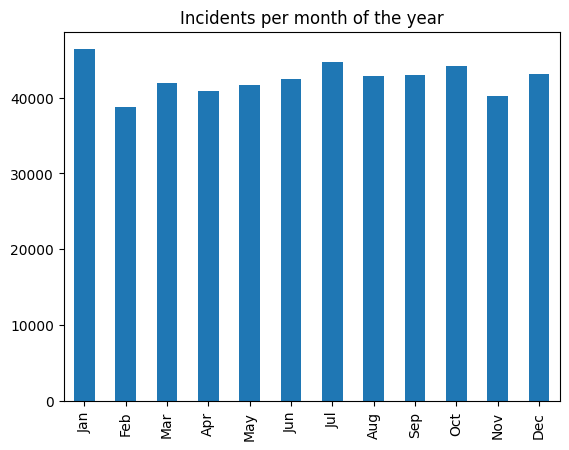

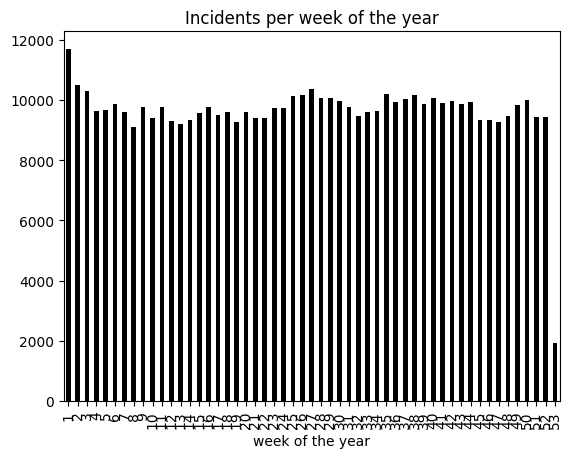

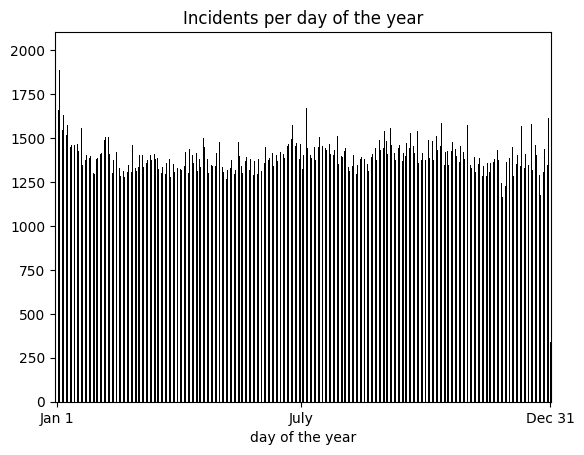

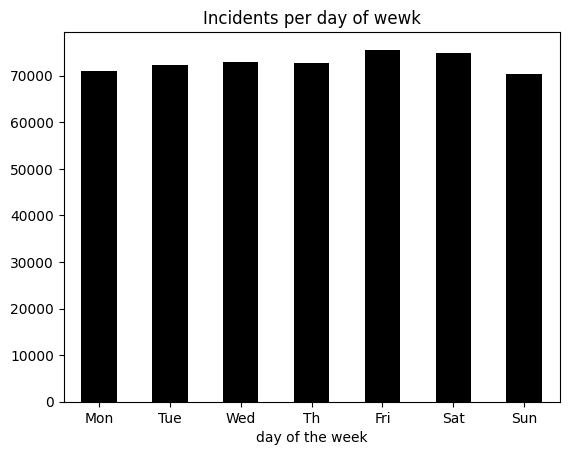

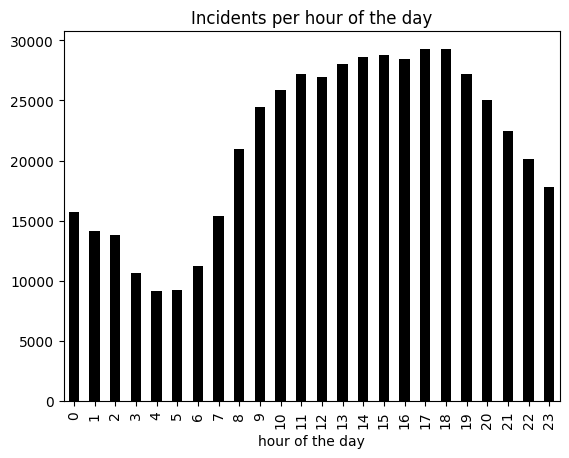

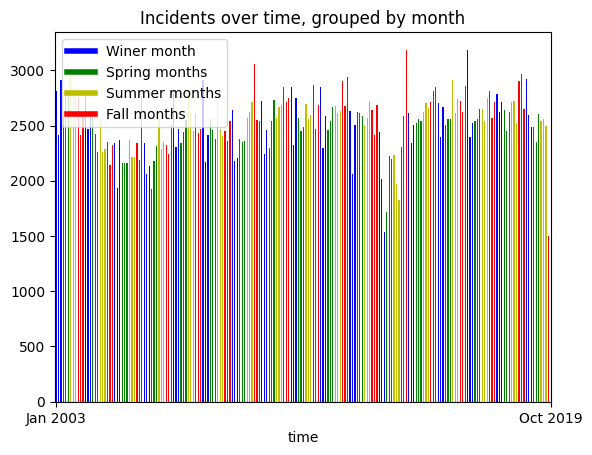

In [10]:
# generate plots of incidents over time before rows with no location are removed
plot_incidents_over_time(df)

#### Plot intentional incidents over time

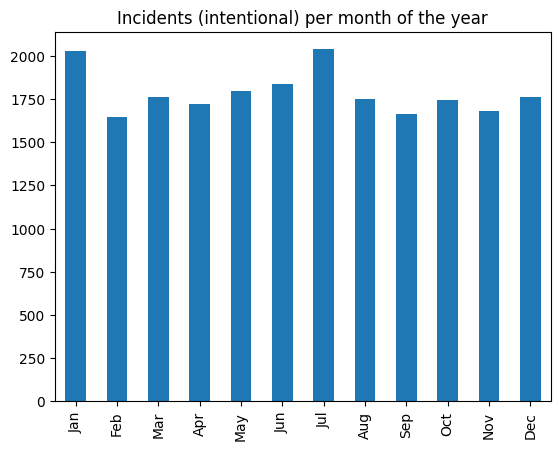

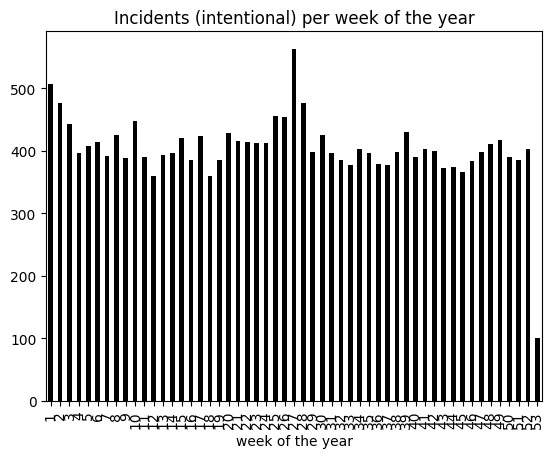

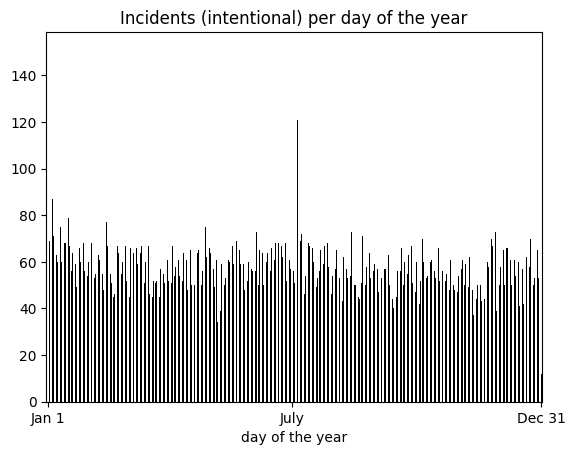

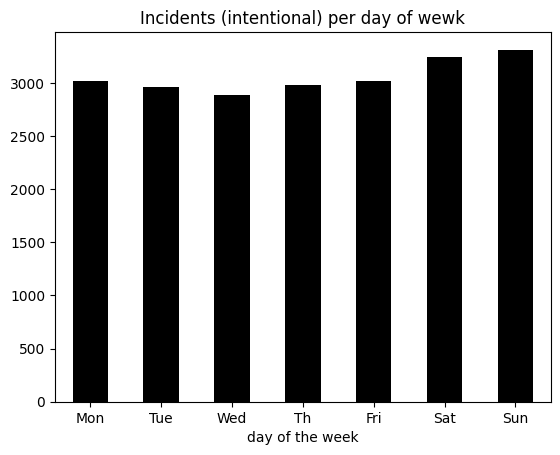

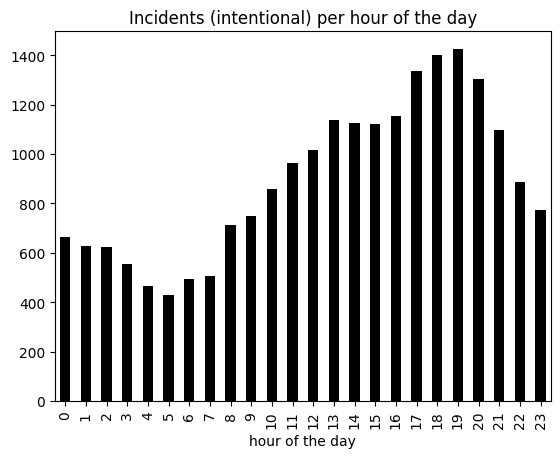

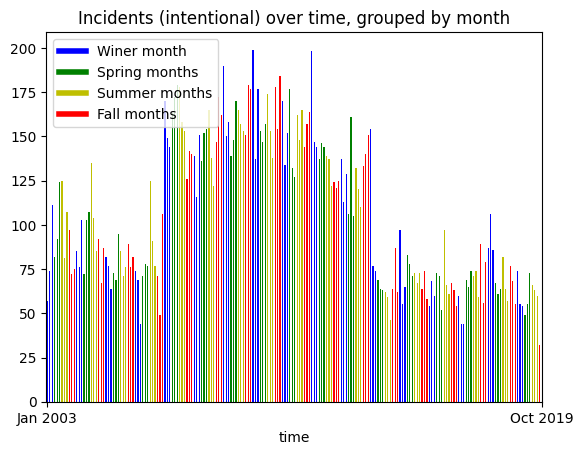

In [11]:
df_intentional = df[df["Intentional"] == True]

plot_incidents_over_time(df_intentional, "intentional")

#### Data cleaning

In [12]:
# filter out incidents with no location (not used for further analisys)
df = df[df.Location.notnull()]

# parse location, get X and Y coordinates into individual columns
df['LocationX'] = df['Location'].apply(lambda x: float(x.replace("("," ").replace(")"," ").split()[1]))
df['LocationY'] = df['Location'].apply(lambda x: float(x.replace("("," ").replace(")"," ").split()[2]))

# drop columns only needed as a source of data for derived columns
df.drop(["Ignition Cause", "Fire Injuries", "Civilian Fatalities", "Civilian Injuries", "Location"], axis=1, inplace=True)

# check if there is still missing values
print("\n---Null counts---")
print(df.isnull().sum())


---Null counts---
Incident Number          0
Incident Date            0
Alarm DtTm               0
Arrival DtTm             0
Suppression Units        0
Suppression Personnel    0
Intentional              0
IndexedMonth             0
Month                    0
Year                     0
Week                     0
Day                      0
Day_Of_Month             0
Day_Of_Week              0
IsHoliday                0
Hour                     0
Injuries                 0
LocationX                0
LocationY                0
dtype: int64


#### Plot all fire incidents by location

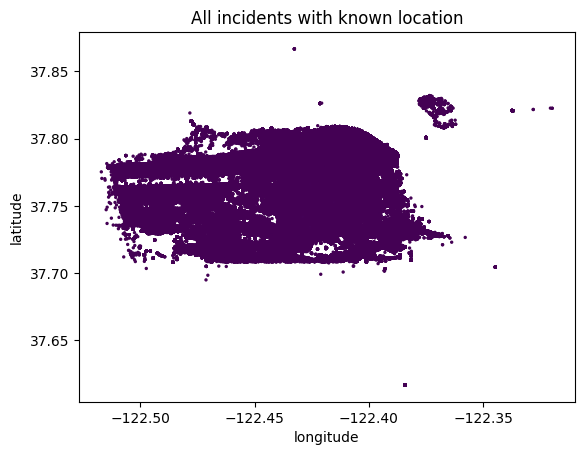

In [13]:
# plot all incidents
plt.scatter(df['LocationX'], df['LocationY'], c=df['Suppression Units'], s=2)
plt.title("All incidents with known location")
plt.xlabel("longitude")
plt.ylabel("latitude")
plt.xticks([-122.5, -122.45, -122.40, -122.35])
xlim = plt.xlim()
ylim = plt.ylim()

#### Plot all intentional fire incidents by location

(37.604409500029526, 37.879222500030025)

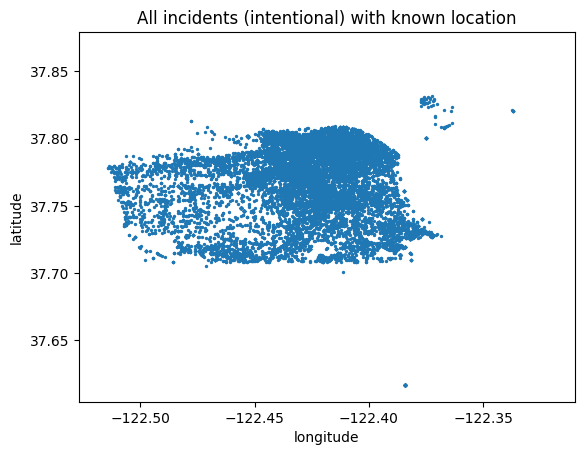

In [14]:
plt.figure()
df_intentional = df[df["Intentional"] == True]
plt.scatter(df_intentional['LocationX'], df_intentional['LocationY'], s=2)
plt.title("All incidents (intentional) with known location")
plt.xlabel("longitude")
plt.ylabel("latitude")
plt.xticks([-122.5, -122.45, -122.40, -122.35])
plt.xlim(xlim)
plt.ylim(ylim)

#### Match fire incidents data with police reports data

In [15]:
df["LocationXapprox"] = df["LocationX"].round(3)
df["LocationYapprox"] = df["LocationY"].round(3)

compare_to_police_reports(df)

LARCENY/THEFT                  497
OTHER OFFENSES                 309
NON-CRIMINAL                   260
ASSAULT                        206
DRUG/NARCOTIC                  129
WARRANTS                       105
VANDALISM                      103
SUSPICIOUS OCC                  98
VEHICLE THEFT                   80
BURGLARY                        71
ROBBERY                         44
MISSING PERSON                  37
FRAUD                           36
ARSON                           23
FORGERY/COUNTERFEITING          19
SEX OFFENSES, FORCIBLE          17
SECONDARY CODES                 17
STOLEN PROPERTY                 17
PROSTITUTION                    16
DISORDERLY CONDUCT              15
TRESPASS                        15
RECOVERED VEHICLE                9
WEAPON LAWS                      9
DRUNKENNESS                      7
DRIVING UNDER THE INFLUENCE      6
LIQUOR LAWS                      5
KIDNAPPING                       5
LOITERING                        3
GAMBLING            

#### Prediction of fire incidents: WHEN

In [16]:
# for "when is the next accident going to happen"
analysis_columns = ["Year", "Month", "Day_Of_Month", "Day_Of_Week", "Hour", "IsHoliday"]
df_regression = df[analysis_columns]

df_regression = df_regression.groupby(analysis_columns).size().reset_index(name='Count')

In [17]:
# create dummy variables
for month in df_regression['Month'].unique():
    monthstr = 'month_' + str(month)
    print(monthstr)
    df_regression[ monthstr ] = df_regression['Month'] == month

for day in df_regression['Day_Of_Week'].unique():
    daystr = 'day_week_' + str(day)
    print(daystr)
    df_regression[ daystr ] = df_regression['Day_Of_Week'] == day

month_1
month_2
month_3
month_4
month_5
month_6
month_7
month_8
month_9
month_10
month_11
month_12
day_week_2
day_week_3
day_week_4
day_week_5
day_week_6
day_week_0
day_week_1


Text(0.5, 1.0, 'Incidents per hour')

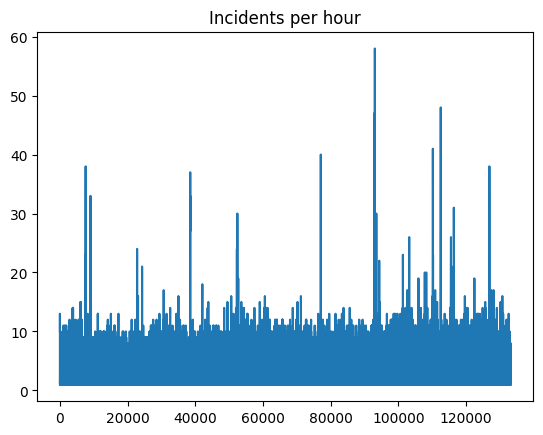

In [18]:
df_count = df_regression["Count"]
df_count.plot(kind="line", x='Index', y="Count")
plt.title("Incidents per hour")

In [19]:
# using regression to predict number of incidents in the next hour
#
# as a raw estimate, and assuming incidents are distributed evenly within the hour,
# this can be used to estimate when the next incident is going to happen
print(list(df_regression.columns))

regcols = ['Year', 'Hour', 'IsHoliday']
for month in df_regression['Month'].unique():
    monthstr = 'month_' + str(month)
    #print(monthstr)
    regcols.append( monthstr )

print( regcols )

for day in df_regression['Day_Of_Week'].unique():
    daystr = 'day_week_' + str(day)
    print(daystr)
    regcols.append( daystr )

print( regcols )

['Year', 'Month', 'Day_Of_Month', 'Day_Of_Week', 'Hour', 'IsHoliday', 'Count', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 'day_week_2', 'day_week_3', 'day_week_4', 'day_week_5', 'day_week_6', 'day_week_0', 'day_week_1']
['Year', 'Hour', 'IsHoliday', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12']
day_week_2
day_week_3
day_week_4
day_week_5
day_week_6
day_week_0
day_week_1
['Year', 'Hour', 'IsHoliday', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 'day_week_2', 'day_week_3', 'day_week_4', 'day_week_5', 'day_week_6', 'day_week_0', 'day_week_1']


In [20]:
# dummy reference categories: month_1, day_week_0
regcols.remove('month_1')
regcols.remove('day_week_0')

# create hour^2 0 to capture non-linear relationship
df_regression['Hour_sqrd'] = df_regression['Hour']**2

regcols.append( 'Hour_sqrd' )

#### Split data into test and train

In [21]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_regression[ regcols ], df_count, test_size=0.2,
                                                    random_state=1)

print(len(regcols))

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

21
(106565, 21)
(26642, 21)
(106565,)
(26642,)


#### Perform linear regression on train set

In [22]:
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train, y_train)

print(regressor.intercept_)
print(regressor.coef_)
print( len(regressor.coef_) )
print( regressor.score(X_train, y_train) )

-122.69910012766191
[ 0.06184672  0.30214415  0.05005847 -0.20989868 -0.24050581 -0.22637827
 -0.29538456 -0.11814132 -0.09485597 -0.19302169 -0.08959015 -0.0634543
 -0.09979007 -0.01443218  0.09293768  0.08373498  0.1769175   0.12466044
 -0.04383593  0.0736304  -0.0099022 ]
21
0.12240361219453577


In [23]:
import statsmodels.api as sm
np.asarray(X_train)
np.asarray(y_train)

for column in X_train:
    print( column )
    X_train[ column ] = X_train[ column ].astype(int)

mod = sm.OLS(y_train, X_train)
fii = mod.fit()
p_values = fii.summary2().tables[1]['P>|t|']

pd.set_option('display.float_format', lambda x: '%.3f' % x)
print( p_values )
print(fii.params)
list(zip(p_values,p_values.index))

Year
Hour
IsHoliday
month_2
month_3
month_4
month_5
month_6
month_7
month_8
month_9
month_10
month_11
month_12
day_week_2
day_week_3
day_week_4
day_week_5
day_week_6
day_week_1
Hour_sqrd
Year         0.000
Hour         0.000
IsHoliday    0.178
month_2      0.000
month_3      0.000
month_4      0.000
month_5      0.000
month_6      0.000
month_7      0.000
month_8      0.000
month_9      0.001
month_10     0.006
month_11     0.000
month_12     0.057
day_week_2   0.000
day_week_3   0.001
day_week_4   0.000
day_week_5   0.000
day_week_6   0.027
day_week_1   0.003
Hour_sqrd    0.000
Name: P>|t|, dtype: float64
Year          0.001
Hour          0.300
IsHoliday     0.052
month_2      -0.225
month_3      -0.252
month_4      -0.234
month_5      -0.306
month_6      -0.127
month_7      -0.106
month_8      -0.202
month_9      -0.099
month_10     -0.080
month_11     -0.142
month_12     -0.056
day_week_2    0.089
day_week_3    0.079
day_week_4    0.170
day_week_5    0.118
day_week_6   -0.051
day_we

[(0.0, 'Year'),
 (0.0, 'Hour'),
 (0.17829530791241288, 'IsHoliday'),
 (4.197231222931522e-14, 'month_2'),
 (6.3140096888944475e-18, 'month_3'),
 (1.4694991429152083e-15, 'month_4'),
 (5.238543151703982e-26, 'month_5'),
 (1.4938590523870375e-05, 'month_6'),
 (0.00025751387674212927, 'month_7'),
 (3.2601539820554264e-12, 'month_8'),
 (0.0006965172475556117, 'month_9'),
 (0.005778171157263467, 'month_10'),
 (1.7664534959430519e-06, 'month_11'),
 (0.0570345557475892, 'month_12'),
 (0.00011399370991069008, 'day_week_2'),
 (0.0005737897940410899, 'day_week_3'),
 (8.518694134732139e-14, 'day_week_4'),
 (2.8530880473203934e-07, 'day_week_5'),
 (0.02703015753651152, 'day_week_6'),
 (0.002692653147474292, 'day_week_1'),
 (0.0, 'Hour_sqrd')]

In [24]:
# Create lists
column_labels = df_regression[ regcols ].columns.tolist()
coef = regressor.coef_.squeeze().tolist()

# Zip together
twodecimals = ["%.2f" % v for v in coef]
labels_coef = list(zip(column_labels, twodecimals))

# Verify the result
print(labels_coef)

y_pred = regressor.predict(X_test)
y_pred = pd.DataFrame(y_pred, columns=['Predicted'])

from sklearn import metrics
import numpy as np
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('R Squared:', metrics.r2_score(y_test, y_pred))

[('Year', '0.06'), ('Hour', '0.30'), ('IsHoliday', '0.05'), ('month_2', '-0.21'), ('month_3', '-0.24'), ('month_4', '-0.23'), ('month_5', '-0.30'), ('month_6', '-0.12'), ('month_7', '-0.09'), ('month_8', '-0.19'), ('month_9', '-0.09'), ('month_10', '-0.06'), ('month_11', '-0.10'), ('month_12', '-0.01'), ('day_week_2', '0.09'), ('day_week_3', '0.08'), ('day_week_4', '0.18'), ('day_week_5', '0.12'), ('day_week_6', '-0.04'), ('day_week_1', '0.07'), ('Hour_sqrd', '-0.01')]
Mean Absolute Error: 1.474330911767954
Mean Squared Error: 3.8249807431187715
Root Mean Squared Error: 1.9557557984366993
R Squared: 0.12397347687897986


Text(0.5, 1.0, 'Observed vs. predicted average fire incidents by hour of day')

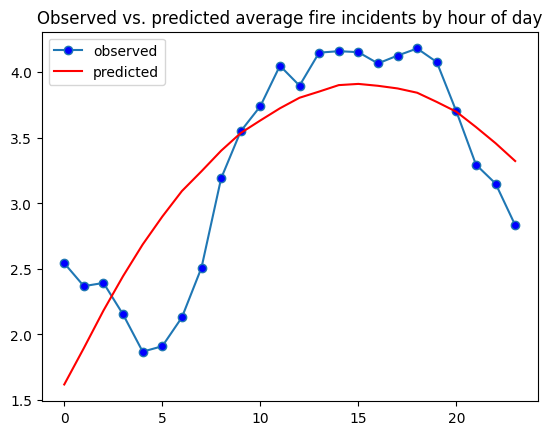

In [25]:
data_test_append = X_test.copy()
data_test_append = data_test_append.reset_index()
data_test_append = data_test_append.drop(['index'], axis=1)

data_test_append['observed'] = list(y_test)
data_test_append['predicted'] = list( regressor.predict(X_test) )

g = data_test_append[['Hour', 'observed', 'predicted']].groupby(['Hour'], as_index=False).mean()

plt.plot( 'Hour', 'observed', data=g, marker='o', markerfacecolor='blue')
plt.plot( 'Hour', 'predicted', data=g, marker='', color='red')
plt.legend()
plt.title('Observed vs. predicted average fire incidents by hour of day')

#### Fire incidents prediction: WHERE
First:
split all locations into 10 blocks by X and 10 blocks by Y (and generate 100 square location blocks)
then:
can use a neural network to predict locations, where each location is an independent class (and thus 100 classes in total)

In [26]:
df['LocXblock'] = pd.qcut(df['LocationX'], 10, labels=False )
df['LocYblock'] = pd.qcut(df['LocationY'], 10, labels=False )
df['LocationBlock'] = df['LocXblock']*10 + df['LocYblock']

loc_predict_columns = ["Year", "Month", "Day_Of_Month", "Day_Of_Week", "Hour", "IsHoliday", "LocationBlock"]
df_location_predict = df[loc_predict_columns]
df_location_predict['IsHoliday'] = df_location_predict['IsHoliday'].apply(lambda x: 1 if x else 0)

num_classes = len(df_location_predict["LocationBlock"].value_counts())

<ipython-input-26-13e703b84d0b>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_location_predict['IsHoliday'] = df_location_predict['IsHoliday'].apply(lambda x: 1 if x else 0)


#### Min-max scaling

In [27]:
# scale data - NNs need it
data_colnames = ["Year", "Month", "Day_Of_Month", "Day_Of_Week", "Hour", "IsHoliday"]
scaler = MinMaxScaler()
# fit simple MinMax data scaler to all data
scaler.fit(df_location_predict[data_colnames])

# scale train data and test data using the same scaler (only input columns)
df_location_predict[data_colnames] = scaler.transform(df_location_predict[data_colnames])

<ipython-input-27-d28b3fd1d508>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_location_predict[data_colnames] = scaler.transform(df_location_predict[data_colnames])


#### Create test and train sets

In [28]:
# generate test and train datasets
X = df_location_predict[data_colnames].values
Y = df_location_predict["LocationBlock"].values

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

# convert output variable to categorical
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

#### Neural network model

In [29]:
model = Sequential()
model.add(Dense(48, input_dim=len(data_colnames), activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

model.fit(X_train, y_train, epochs=20, validation_split=0.1)

model.evaluate(X_test, y_test)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 48)                336       
                                                                 
 dense_1 (Dense)             (None, 16)                784       
                                                                 
 dense_2 (Dense)             (None, 100)               1700      
                                                                 
Total params: 2820 (11.02 KB)
Trainable params: 2820 (11.02 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/20
10036/10036 [==============================] - 35s 3ms/step - loss: 4.4699 - accuracy: 0.0302 - val_loss: 4.4600 - val_accuracy: 0.0356
Epoch 2/20
10036/10036 [==============================] - 32s 3ms/step - loss: 4.4581 - accuracy: 0.0347 - val_loss: 4.4556 - val_accuracy:

[4.448421955108643, 0.03634284809231758]